## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import geocoder
from geopy.geocoders import Nominatim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

from bs4 import BeautifulSoup
import requests

## 2. Data Extraction

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
Canada_data = BeautifulSoup(source, 'lxml')

In [3]:
column_names = ['Postalcode','Borough','Neighbourhood']
toronto = pd.DataFrame(columns = column_names)
content = Canada_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighbourhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip()
            i = i + 1
        elif i == 1:
            borough = td.text.strip()
            i = i + 1
        elif i == 2: 
            neighbourhood = td.text.strip()
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighbourhood': neighbourhood},ignore_index=True)

In [4]:
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)

In [5]:
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()

def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighbourhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighbourhood')
df2.rename(columns={'Postalcode':'Postal Code'}, inplace=True)
df2.head(11)

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [6]:
df2.describe()

,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M4A,North York,Downsview
freq,1,24,4


In [7]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [ ]:
postal_codes = df2['Postal Code']
cords = [get_latilong(postal_codes) for postal_code in postal_codes.tolist()]

In [8]:
geocv = pd.read_csv('http://cocl.us/Geospatial_data').set_index('Postal Code')
geocv.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [10]:

final_df = pd.merge(geocv,df2,on='Postal Code')
final_df.head()

,Postal Code,Latitude,Longitude,Borough,Neighbourhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [13]:
df = final_df[['Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [124]:
address = 'North York'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude_ny, longitude_ny))

The geograpical coordinate of North York are 43.7543263, -79.44911696639593.


In [125]:
map_ny = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)

# add markers to map
for lat, lng,  Neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny


In [126]:
from geopy.geocoders import Nominatim

address = 'North York'

geolocator = Nominatim(user_agent='ON')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_n1, longitude_n1))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


In [127]:
CLIENT_ID = 'QZNHC04HBTSAJYZXVBBO0RHHE0WMPIQVARIVVFBRIRCI0XEN' # my Foursquare ID
CLIENT_SECRET = 'GPXZFD4OGTKOB4NU0MXPKMRII2UD4R3NGO0YYG3VGMSJBBKT' # my Foursquare Secret
VERSION = '20200730'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: QZNHC04HBTSAJYZXVBBO0RHHE0WMPIQVARIVVFBRIRCI0XEN
CLIENT_SECRET: GPXZFD4OGTKOB4NU0MXPKMRII2UD4R3NGO0YYG3VGMSJBBKT


In [128]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f22e66adbd14a765164d0d5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bathurst Manor',
  'headerFullLocation': 'Bathurst Manor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 12,
  'suggestedBounds': {'ne': {'lat': 43.76062630630001,
    'lng': -79.44041124686424},
   'sw': {'lat': 43.74802629369999, 'lng': -79.45782268592762}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5a888f7647f8767d37b92f00',
       'name': 'Grill Gate',
       'location': {'address': '832 Sheppard West',
        'crossStreet': 'NE corner of Sheppard & Wilmington',
        'lat': 43.753122978404804,
        'lng': -79.45169001817703,
 

In [129]:
import json


venues=results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [130]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Nearby venues/Locaions

In [131]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


## Categories of nearby Venues/Locations

In [132]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [133]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  2
Fried Chicken Joint          1
Restaurant                   1
Deli / Bodega                1
Sushi Restaurant             1
Bus Line                     1
American Restaurant          1
Coffee Shop                  1
Mediterranean Restaurant     1
Middle Eastern Restaurant    1
Name: categories, dtype: int64

In [156]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [157]:
North_York_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [158]:
North_York_venues.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
1,Woburn,43.770992,-79.216917,Korean Grill House,43.770812,-79.214502,Korean Restaurant
2,Scarborough Village,43.744734,-79.239476,McCowan Park,43.745089,-79.239336,Playground
3,"Birch Cliff, Cliffside West",43.692657,-79.264848,The Birchcliff,43.691666,-79.264532,Café
4,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Scarborough LRT,43.756465,-79.272194,Light Rail Station


## One hot encoding

In [159]:
NY_onehot = pd.get_dummies(North_York_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighbourhood'] = North_York_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot.head()

,Accessories Store,Adult Boutique,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flower Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Home Service,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Lawyer,Light Rail Station,Liquor Store,Martial Arts Dojo,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Music Store,Music Venue,Neighborhood,New American Restaurant,Noodle House,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoothie Shop,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Rouge Hill, Port Union, Highland Creek"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Woburn
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Scarborough Village
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Birch Cliff, Cliffside West"
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Dorset Park, Wexford Heights, Scarborough Town..."


In [160]:
NY_grouped = NY_onehot.groupby('Neighbourhood').mean().reset_index()
NY_grouped

,Neighbourhood,Accessories Store,Adult Boutique,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flower Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Home Service,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Lawyer,Light Rail Station,Liquor Store,Martial Arts Dojo,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moroccan Restaurant,Movie Theater,Music Store,Music Venue,Neighborhood,New American Restaurant,Noodle House,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoothie Shop,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Alderwood, Long Branch",0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.0

In [161]:
num_top_venues = 5

for hood in NY_grouped['Neighbourhood']:
    print("---- "+hood+" ----")
    temp = NY_grouped[NY_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Alderwood, Long Branch ----
                venue  freq
0         Pizza Place  0.33
1         Coffee Shop  0.33
2            Pharmacy  0.33
3         Music Venue  0.00
4  Mexican Restaurant  0.00


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Pizza Place  0.14
1                Coffee Shop  0.14
2  Middle Eastern Restaurant  0.14
3           Sushi Restaurant  0.14
4        Fried Chicken Joint  0.14


---- Bedford Park, Lawrence Manor East ----
                     venue  freq
0       Italian Restaurant   0.2
1  Comfort Food Restaurant   0.1
2              Coffee Shop   0.1
3           Breakfast Spot   0.1
4           Sandwich Place   0.1


---- Birch Cliff, Cliffside West ----
                       venue  freq
0                       Café   1.0
1          Accessories Store   0.0
2                Music Venue   0.0
3         Mexican Restaurant   0.0
4  Middle Eastern Restaurant   0.0


---- Business reply mail Processi

## Return the most common venues 

In [162]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Getting most common venues near the neighburhood

In [163]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = NY_grouped['Neighbourhood']

for ind in np.arange(NY_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alderwood, Long Branch",Pharmacy,Pizza Place,Coffee Shop,Yoga Studio,Cupcake Shop,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store
1,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Middle Eastern Restaurant,Fried Chicken Joint,Deli / Bodega,Restaurant,Sushi Restaurant,Yoga Studio,Cupcake Shop,Dim Sum Restaurant
2,"Bedford Park, Lawrence Manor East",Italian Restaurant,Comfort Food Restaurant,Sushi Restaurant,Breakfast Spot,Sandwich Place,Coffee Shop,Juice Bar,Cosmetics Shop,Fast Food Restaurant,Discount Store
3,"Birch Cliff, Cliffside West",Café,Yoga Studio,Department Store,Dumpling Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Deli / Bodega
4,"Business reply mail Processing Centre, South C...",Brewery,Auto Workshop,Department Store,Electronics Store,Dumpling Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop


## K-means Clustering

In [164]:
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

kmeans.labels_ 

array([3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 4,
       0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1])

In [176]:
#neighbourhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

NY_merged =df.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

NY_merged.head()# check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,North York,"Malvern, Rouge",43.806686,-79.194353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1C,North York,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,4.0,Golf Course,Deli / Bodega,Dumpling Restaurant,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Cupcake Shop
2,M1E,North York,"Guildwood, Morningside, West Hill",43.763573,-79.188711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M1G,North York,Woburn,43.770992,-79.216917,1.0,Korean Restaurant,Yoga Studio,Deli / Bodega,Dog Run,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Cupcake Shop
4,M1H,North York,Cedarbrae,43.773136,-79.239476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
kclusters = 5

map_clusters = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NY_merged['Latitude'], 
                                   NY_merged['Longitude'], 
                                   NY_merged['Neighbourhood'], 
                                   NY_merged['ClusterLabels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster],
        fill=True,
        #fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']


## Housing Price in North York

In [117]:
df1=NY_merged.loc[NY_merged['ClusterLabels'] == 0,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]
df2=NY_merged.loc[NY_merged['ClusterLabels'] == 1,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]
df3=NY_merged.loc[NY_merged['ClusterLabels'] == 2,NY_merged.columns[[2] + list(range(5, NY_merged.shape[1]))]]

In [118]:
NY_Avg_HousingPrice=pd.DataFrame({"Neighbourhood":df["Neighbourhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [119]:
NY_Avg_HousingPrice.set_index('Neighbourhood',inplace=True,drop=True)

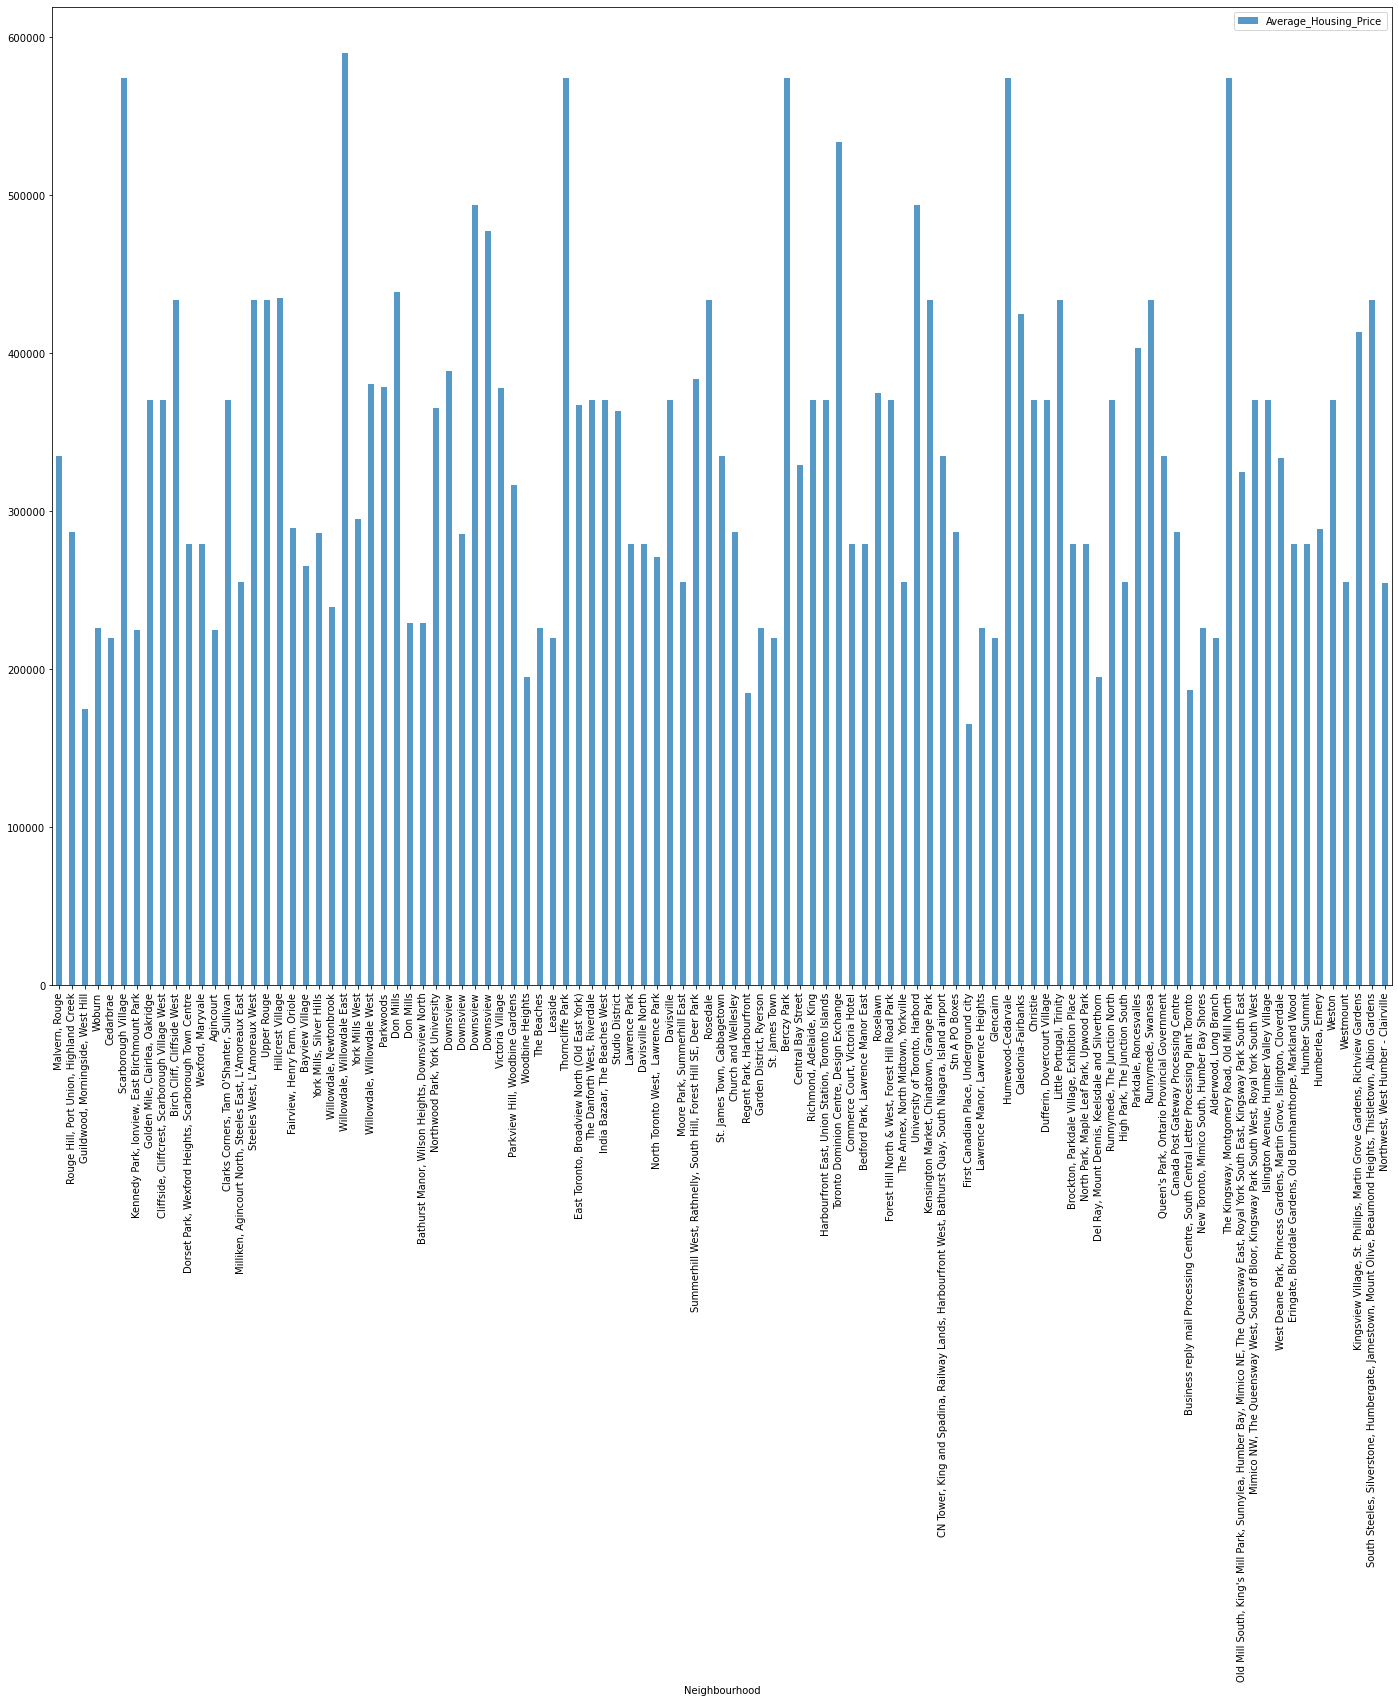

In [120]:
NY_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## School ratings

In [105]:
clusters=pd.DataFrame({"Cluster1":df1["Neighbourhood"],
                      "Cluster2":df2["Neighbourhood"],
                      "Cluster4":df3["Neighbourhood"]})
clusters = clusters.replace(np.nan, '', regex=True)


In [106]:
new_NY=NY_merged.set_index("Neighbourhood",drop=True)
#Source:https://www.greatschools.org
NY_school_ratings=pd.DataFrame({"Neighbourhood":df["Neighbourhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [107]:
NY_school_ratings.set_index('Neighbourhood',inplace=True,drop=True)

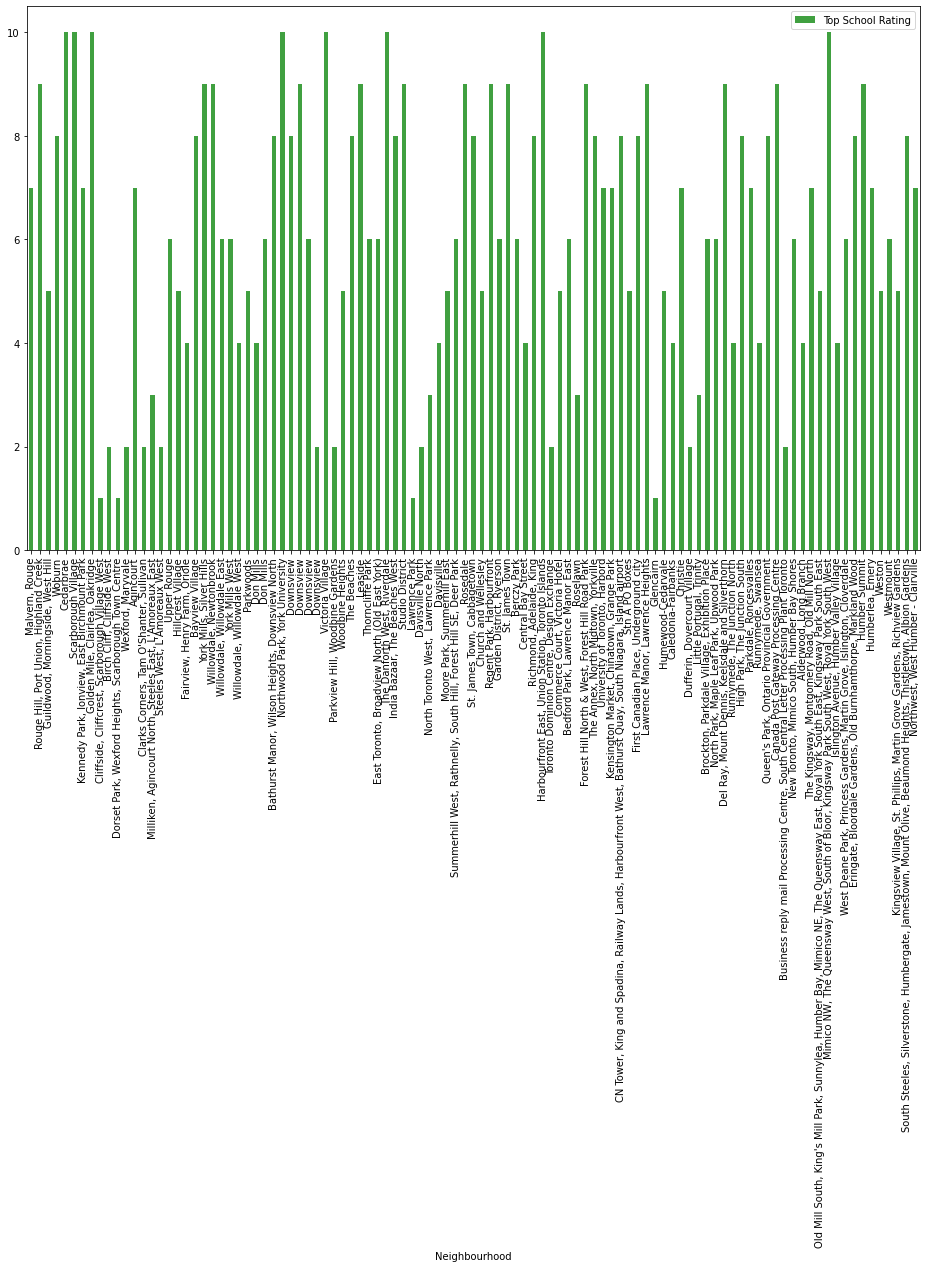

In [108]:
NY_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

**Conclusion:** In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made